<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/GymTaxiDoubleQLearningTODO.ipynb" target="_parent">Ouvrir sous colab</a>

# Machine Learning
## Appliqué à [Gym.OpenAI](https://gym.openai.com)

---
## Test de ML par Q-Learning pour atteindre des objectifs

**Utilisation de l'environnement gymnasium**
 (voir la page d'introduction à [gymnasium](https://www.gymlibrary.dev/)).

#### Si besoin, importer gym

In [1]:
#!pip install gymnasium 

----
#### L'environnement Taxi

In [1]:
import gymnasium as gym

---
- Utiliser l'environnement `Taxi-v3`
  - le taxi peut se trouver sur une grille 5x5
  - le passager peut se trouver : dans le taxi, ou dans un des 4 points B(3),G(1),R(0),Y(2). 
  - il y a en tout $500$ états possibles : $25\times 5 \times 4$
  - chaque état est representé par un ensemble: (rangee_taxi, colonne_taxi, position_passager, destination_passager)

- les actions sont :
  - 0: sud, 1: nord, 2: est, 3: ouest, 4: prendre un passager, 5: déposer un passager

- les récompenses sont : 
    - dépôt d'un passager à destination : +20 points
    - action prise en charge incongrue d'un passager : -10 points
    - dans les autres cas, chaque état coûte 1 point

- Chaque action coûte 1 point, l'arrivée n'en rapporte pas.



---
#### Etude de l'environnement

In [4]:
env = gym.make('Taxi-v3', render_mode='ansi') 
print("specification de l'environnement : ", env.spec)
print("espace d'actions : ", env.action_space ) # actions discrétisée
print("espace d'etats : ", env.observation_space) # cellules possibles
actions = { 0:'sud', 1:'nord', 2:'est', 3:'ouest', 4:'prendre un passager', 5: 'déposer un passager'}
lieux = {0:'R', 1:'G', 2:'Y', 3:'B'}

s = env.reset()
print(env.render())

print("********l'etat initial change à chaque reset***** ici s= ",s)
x,y,passager_start, passager_end  = env.unwrapped.decode(s[0])
print(f"--> cela correspond à un taxi en ({x},{y}), un passager partant de {lieux[passager_start]} pour {lieux[passager_end]}")

print("Prendre une action au hasard.. ")
a = env.action_space.sample()
print("action choisie=",actions[a],"; l'exécuter...")
#on recupère des valeurs en retour
new_s, reward, done, truncated, info = env.step(a)
print(f"nouvel état={new_s}, recompense sur cet etat={reward}, etat final (but)={done}, etat feuille={truncated}, info={info}")
#note sous python 3.10, la version de gym retourne 5 valeurs : 
#new_s, reward, done, goal, info = env.step(a)
#print(f"nouvel état={new_s}, recompense sur cet etat={reward}, etat final (but)={done},etat but={goal}, info={info}")

print(env.render())


specification de l'environnement :  EnvSpec(id='Taxi-v3', entry_point='gymnasium.envs.toy_text.taxi:TaxiEnv', reward_threshold=8, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_checker=False, kwargs={'render_mode': 'ansi'}, namespace=None, name='Taxi', version=3, additional_wrappers=(), vector_entry_point=None)
espace d'actions :  Discrete(6)
espace d'etats :  Discrete(500)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


********l'etat initial change à chaque reset***** ici s=  (92, {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 0, 0], dtype=int8)})
--> cela correspond à un taxi en (0,4), un passager partant de B pour R
Prendre une action au hasard.. 
action choisie= prendre un passager ; l'exécuter...
nouvel état=92, recompense sur cet etat=-10, etat final (but)=False, etat feuille=False, info={'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 0, 0], dtype=int8)}
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |

---
#### Test des actions

Sous Gym, `step` permet d'effectuer une action. 
En retour la fonction retourne une observation sur l'etat d'arrivee, sa recompense, son type (final ou non), et des informations.

Avec la librairie gym installé sous python 3.9, step retourne : 
  - observation = position où se trouve l'agent,
  - reward = recompense,
  - done = vrai si état final atteint,
  - info = probabilité de succès de l'action.
  
Avec la librairie gym installé sous python 3.10, step retourne : 
  - observation = position où se trouve l'agent,
  - reward = recompense,
  - done = vrai si état final atteint,
  - goal = vrai si but atteint,
  - info = probabilité de succès de l'action.

---
### <font color="red">Résolution</font>


---
## Exemple d'algorithme

In [ ]:
import numpy as np
import random as rnd
from tqdm import tqdm

env = gym.make('Taxi-v3', render_mode='ansi') 
actions = { 0:'sud', 1:'nord', 2:'est', 3:'ouest', 4:'prendre un passager', 5: 'déposer un passager'}
lieux = {0:'R', 1:'G', 2:'Y', 3:'B'}


In [ ]:
# initialiser la Q-Table
# autant de cases que l'environnement en possède, 
# contenant autant de valeurs que d'actions possibles
# donc ici une matrice 500 x 6
QA = np.zeros([env.observation_space.n,env.action_space.n])
QB = np.zeros([env.observation_space.n,env.action_space.n])

### Mise en place des paramètres

Pour rappel avec l'algo de Double Q Learning, on réalise, plus ou moins alternativement :
  - $a^* \gets  argmax_{a} QA(s', a)$,
  - $Q_A(s,a) \gets Q_A(s,a) + \lambda \times (r + \gamma \times Q_B(s', a^*))-  Q_A(s,a))$ <br>
ou<br>
  - $b^* \gets  argmax_{a} Q_B(s', a)$
  - $Q_B(s,a) \gets Q_B(s,a) + \lambda \times (r + \gamma \times QA(s', b^*))-  Q_B(s,a))$<br>
avec 
    - $\lambda$ : coef d'apprentissage
    - $\gamma$ : coef de réduction 
    - $r$ : récompense

Cette équation note la qualité de l'action *a* à partir de l'état *s* alternativement dans les tables $Q_A$ et $Q_B$.

Initialement, les actions sont choisies aléatoirement et notées; puis au fil des tests les actions les plus valuées sont choisies. Pour cela, un tirage est effectuée, s'il est inférieur à un $\epsilon$, le choix est aléatoire. Cet $\epsilon$ décroit au fil des tests.

In [ ]:
lambda_learn = .2
gamma = 0.99
epsilon = 1.
reduc_epsilon = 0.99

#### Récupérer la meilleure action
`argmax(tab)` retourne l'indice de la plus grande valeur du tableau.

`argmax(Q[2])` retourne donc le no de l'action la plus intéressante à partir de l'état 2.

## L'algorithme de DoubleQ-Learning 

In [ ]:
np.max(QA[0, :])

0.0

In [ ]:
##algorithme de Q-Learning simple
def double_q_learn(nb_actions=64):
    """
    effectue un cycle d'apprentissage/recherche de solution' via le Q-Learning simple

    Parameters
    ----------
    epoch : no de l'etape

    Returns
    -------
    total_r : recompense totale
    r : recompense du dernier etat rencontre
    states_list : liste des etats traverses
    actions_list : liste des actions effectuees
    goal : but atteint

    """
    s = env.reset()
    #sous python 3.10, ajouter
    s = s[0]
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []

    # The Q-Table learning algorithm
    while not done and step < nb_actions:
        step += 1
        # Choose an action by greedily (with noise) picking from Q table
        actionsA = QA[s, :]
        actionsB = QB[s, :]
        actions = actionsA + actionsB
        if rnd.random()<epsilon or np.max(actions)==0:
            a = rnd.randint(0, env.action_space.n-1)
        else:
            a = np.argmax(actions)

        # Get new state and reward from environment
        new_state, r, done, _, _ = env.step(a)

        # Q-Learning
        if (rnd.random() < 0.5):
            future_actions = QA[new_state, :]
            #si aucune future action intéressante, en prendre une au hasard
            if max(future_actions==0): future_actions = QB[new_state, :]
            if max(future_actions==0): aeto = env.action_space.sample()
            else: aeto= np.argmax(future_actions)
            QA[s, a] = QA[s, a] + lambda_learn*(r + gamma * QA[new_state, aeto] - QA[s, a])
        else:
            future_actions = QB[new_state, :]
            #si aucune future action intéressante, en prendre une au hasard
            if max(future_actions==0): future_actions = QA[new_state, :]
            if max(future_actions==0): beto = env.action_space.sample()
            else: beto= np.argmax(future_actions)
            QB[s, a] = QB[s, a] + lambda_learn*(r + gamma * QB[new_state, beto] - QB[s, a])

        s = new_state
        total_r = total_r + r
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list, done

In [ ]:
def try_qlearn(nb_episodes = 4000, nb_actions = 64):
    """
    lance nb_episodes fois un cycle de Q-Learning et memorise chaque solution trouvee

    Returns
    -------
    solutions_list : liste des solutions (no, recompense totale, liste des etats, liste des actions)
    """
    global epsilon
    epsilon = 1.
    states_list = []
    actions_list = []
    solutions_list = []
    epsilon = 1
    for i in tqdm(range(nb_episodes)):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list, done = double_q_learn(nb_actions)
        epsilon = epsilon * reduc_epsilon
        # memorize if a solution has been found
        if done: solutions_list.append((i, total_r, states_list, actions_list))
    if(len(solutions_list) == 0): print("aucune solution trouvee !!")
    return solutions_list

## Affichage de du résultat
Affichons maintenant la liste des actions via l'environnement Gymnasium

In [ ]:
def exemple_resolution():
    """ affiche un exemple de solution calculée à partir d'une des tables Q"""
    s = env.reset()
    s = s[0]
    x,y,depart_passager, arrivee_passager = env.unwrapped.decode(s)
    print(f"à partir de ({x},{y}), prendre un client en {lieux[depart_passager]} pour l'amener en {lieux[arrivee_passager]}")
    goal = False
    while not goal:
        a = np.argmax(QA[s, :])
        s,_,goal,_,_ = env.step(a)
        x,y,pos_passager, but_passager = env.unwrapped.decode(s)
        goal = pos_passager==but_passager
        print(env.render())

In [ ]:
def reset():
    global epsilon, lambda_learn, gamma, reduc_epsilon
    lambda_learn = .3
    gamma = 0.99
    epsilon = 1.
    reduc_epsilon = 0.999
    QA.fill(0)
    QB.fill(0)

In [ ]:
##ON LANCE LA RESOLUTION : 
reset()
solutions = try_qlearn(15000, 50)
if(len(solutions)==0):print("pas de solution...")
#relancer le bloc si pas de solution trouvee

100%|██████████| 15000/15000 [00:06<00:00, 2389.71it/s]


In [ ]:
##ON TESTE UNE RESOLUTION : 
if(len(solutions)>0):exemple_resolution()

à partir de (4,2), prendre un client en G pour l'amener en R
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  

In [ ]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.show()



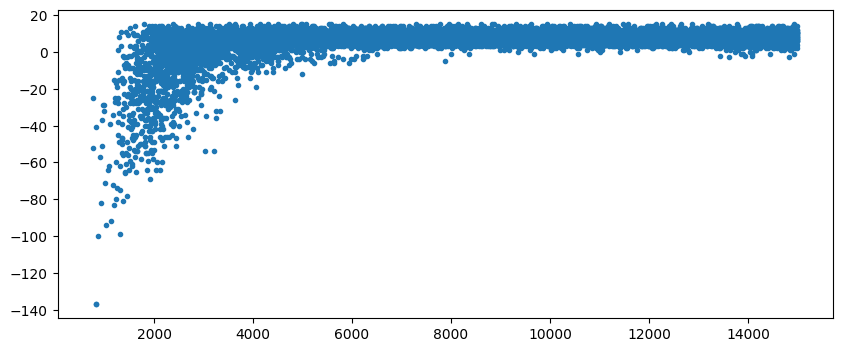

In [ ]:
plot_frequence_sol(solutions)

np.round(QA, 3)

Plus on relance les tests, plus on a de chance de trouver une solution peu coûteuse apparaît...